# **Deep Learning Project - Roman, Bonetto, Dian**



## **Introduction**

Deep neural networks (DNNs) often encounter significant performance degradation when subjected to images that differ substantially from those seen during training. This issue, known as **domain shift**, poses a critical challenge in deploying DNNs across diverse and unseen environments. For instance, when we evaluate a ResNet-50 model pre-trained on the ImageNet-1k dataset on ImageNet-A, which consists of challenging and naturally occurring adversarial images, the model's accuracy drops markedly. This stark performance drop underscores the model's limited robustness to domain shifts and highlights the need for methods that can effectively adapt to new and diverse datasets.

Our project is centered on researching and developing techniques to enhance the performance of **Marginal Entropy Minimization with One test point (MEMO)**, specifically aiming to improve model accuracy in the face of domain shift challenges. Our goal is to refine MEMO to better handle such discrepancies, ensuring robust and accurate model performance across diverse and unseen datasets.



## **Methodology**

### **Model description - From Resnet50 to VitB16**

We began our exploration with the ResNet-50 architecture, leveraging its well-established effectiveness and pre-training on the ImageNet-1k dataset as a robust foundation .

Our project began with the ResNet-50 architecture, a convolutional neural network (CNN) known for its effectiveness in various image analysis tasks due to its ability to capture hierarchical features through convolutional layers and residual connections. Pre-trained on the extensive ImageNet-1k dataset, ResNet-50 was expected to provide a strong starting point for our work. However, our initial experiments revealed that ResNet-50's performance on ImageNet-A, which consists of naturally adversarial images, was markedly poor.

> *This underscored the **limitations of CNNs in capturing global context and long-range dependencies effectively**, as they rely heavily on local convolutional filters that process information in a fragmentary, hierarchical manner.*

In contrast, **Vision Transformers (ViTs)** like the ViT-B/16, which we subsequently adopted, offer a more holistic approach to image analysis. 

> *ViT-B/16 processes images by **dividing them into fixed-size patches**, treating each patch as a token in a sequence. Unlike CNNs, where each convolutional filter only interacts with a local neighborhood, the Vision Transformer employs self-attention mechanisms to capture relationships between distant patches across the entire image simultaneously. This enables the model for example, to establish connections between a patch in the top-left corner and one in the bottom-right corner in a single pass, effectively capturing global context and spatial relationships.*

<p align="center">
  <img src="https://miro.medium.com/v2/resize:fit:1400/1*l37va2Mu8Snx6LLb13430A.png" alt="ViT architecture" width="700" />
</p>

We decided to switch to ViT-B/16 knowing his superior ability to **model long-range dependencies and global interactions directly**, which proved crucial in addressing the domain shift challenges we encountered. The Vision Transformer’s capacity to understand complex spatial relationships and adapt to various data distributions was confirmed through our evaluations on challenging ImageNet-A, where it demonstrated significant improvements in robustness and accuracy over the initial ResNet-50 baseline. This transition not only enhanced our model’s adaptability to diverse and unseen environments but also provided a robust framework for our further advancements in test-time adaptation techniques.

<br>

We start by importing all the libraries: 

In [1]:
import cv2
import torch
import random
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import os
from PIL import Image, ImageFilter
import torchvision.transforms as T

ImportError: libGL.so.1: cannot open shared object file: No such file or directory

Then we define our VitB16 model (we define also the ResNet50 model to use it as comparison):

In [ ]:
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights, vit_b_16, ViT_B_16_Weights

class ModelResNet(nn.Module):

    def __init__(self):
        super(ModelResNet, self).__init__()

        self.resnet50 = resnet50(weights=ResNet50_Weights.DEFAULT)
        
    def forward(self, input):
        
        output = self.resnet50(input)

        return output

class ModelVitb16(nn.Module):

    def __init__(self):
        super(ModelVitb16, self).__init__()

        self.vitb = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)
        
    def forward(self, input):
        
        output = self.vitb(input)

        return output



### **Dataset - Imagenet-A**

As we mentioned earlier, we're using a pre-trained Vision Transformer (ViT), specifically ViT-B. While ViT-B has been trained on a large dataset called ImageNet-21k, our main goal is to ensure it **performs well on ImageNet-A**. ImageNet-A is known for its tough and diverse images that differ significantly from those in standard ImageNet datasets.

ImageNet-A consists of around **7500 images** spread across **200 classes**. Each image is carefully chosen to challenge models with complex visual variations and anomalies. This dataset is quite different from the original ImageNet-1k, which has **1000 classes** and is commonly used for standard image classification tasks.

Our aim is to fine-tune ViT-B so that it can handle the unique characteristics of ImageNet-A effectively. This means adapting ViT-B's learned features to better understand and classify the kinds of images found in ImageNet-A. 

However, vanilla version of ViT-B doesn't perform well on Imagenet-A, so our mission will be to show where it falls short on ImageNet-A and come up with new techniques to make it perform way better. 

<br>

We define a function that instantiate our data loader to preprocess the data:

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Prepare data transformations for the train loader
transform = T.Compose([
    T.Resize((256, 256)),                                                   # Resize each PIL image to 256 x 256
    T.RandomCrop((224, 224)),                                               # Randomly crop a 224 x 224 patch
    T.ToTensor(),                                                           # Convert Numpy to Pytorch Tensor
    T.Normalize(mean, std)                                                  # Normalize with ImageNet mean
])

def get_dataset(batch_size, img_root, num_workers=2):
    # Load data
    imagnet_dataset_4test = torchvision.datasets.ImageFolder(root=img_root, transform=transform)
    imagnet_dataset_4memo = torchvision.datasets.ImageFolder(root=img_root)

    # Initialize dataloaders
    test_loader_4test = torch.utils.data.DataLoader(imagnet_dataset_4test, batch_size, shuffle=False, num_workers=num_workers)

    return test_loader_4test, imagnet_dataset_4memo

current_dir = os.getcwd()
pathDatasetImagenetA = os.path.join(current_dir, "datasets/imagenet-a")

### **Loss function**

Now, we implement the loss function that will be the marginal entropy, which is a central point of MEMO implementation:

$$
  H(\bar{p_{\theta}}(\cdot|x)) = - \sum_{y \in Y}\bar{p_{\theta}}(y|x)\,\,log\,\bar{p_{\theta}}(y|x)
$$

while our $\bar{p_{\theta}}(y|x)$ is:

$$
  \bar{p_{\theta}}(y|x) = \mathbf{E}_{U(A)} [p_{\theta}(y|a(x))]= \frac{1}{B} \sum_{i=1}^{B} p_{\theta}(y|\tilde{x_i})
$$

This computes the expected probability of each class $y$ given input $x$, averaging predictions across $B$ perturbed samples $\tilde{x_i}$​. 

Marginal entropy is ideal for MEMO because it minimizes **prediction uncertainty across varied inputs $\mathbf{x}$**. By averaging predictions over perturbed samples, it enhances model stability and performance on diverse datasets like ImageNet-A.


In [ ]:
def marginal_entropy(outputs):
    logits = outputs - outputs.logsumexp(dim=-1, keepdim=True)
    avg_logits = logits.logsumexp(dim=0) - np.log(logits.shape[0])
    min_real = torch.finfo(avg_logits.dtype).min
    avg_logits = torch.clamp(avg_logits, min=min_real)
    return -(avg_logits * torch.exp(avg_logits)).sum(dim=-1), avg_logits

### **Augmentations **

Original implementation of MEMO incorporated advanced augmentations like *DeepAugment*, *AugMix*, moment exchange, and *CutMix* to increase the versatility and robustness of input images. However, we have chosen a more straightforward approach for our implementation, focusing primarily on augmentations implemented using mainly OpenCV. 

All augmentation implementations are stored in the file `augmentations.py`.

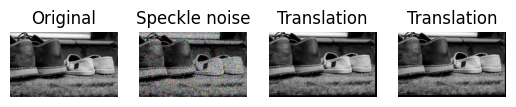

In [ ]:
from augmentations import *

augmentations_names = [
    "Rotation",
    "Zoom",
    "Horizontal flip",
    "Vertical flip",
    "Greyscale",
    "Inverse",
    "Blur",
    "Crop",
    "Affine",
    "Change gamma",
    "Translation",
    "Scale",
    "Brightness",
    "Histogram equalization",
    "Salt and pepper",
    "Gaussian blur",
    "Poisson noise",
    "Speckle noise",
    "Contrast",
]

def apply_augmentations(img, num_aug):
    ret_images = []
    ret_names = []

    ret_images.append(img)
    ret_names.append("Original")

    for i in range(num_aug):
        img_copy = img.copy()

        # Convert PIL image to NumPy array
        img_np = np.array(img_copy)

        n = random.randint(0, len(augmentations)-1)

        # Apply augmentation
        img_aug_np = augmentations[n](img_np)

        # Convert NumPy array back to PIL image
        img_aug = Image.fromarray(img_aug_np)

        ret_images.append(img_aug)
        ret_names.append(augmentations_names[n])

    return ret_images, ret_names

img = Image.open(get_random_imagenet_a_image(pathDatasetImagenetA))

aug, names = apply_augmentations(img, 3)

for i in range(len(aug)):
    plt.subplot(1, len(aug), i+1)
    plt.imshow(aug[i])
    plt.title(names[i])
    plt.axis('off')

plt.show()



spiegare perchè ne abbiamo selezionate un numero limitato


## **Experiments and results**

For all experiments we'll use we'll use AdamW as optimizer with $\eta = 2.5\cdot 10^{-4}$ that will remain consistent across all experiments to maintain a standardized benchmark.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

thousand_k_to_200 = {0: -1, 1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 6: 0, 7: -1, 8: -1, 9: -1, 10: -1, 11: 1, 12: -1, 13: 2, 14: -1, 15: 3, 16: -1, 17: 4, 18: -1, 19: -1, 20: -1, 21: -1, 22: 5, 23: 6, 24: -1, 25: -1, 26: -1, 27: 7, 28: -1, 29: -1, 30: 8, 31: -1, 32: -1, 33: -1, 34: -1, 35: -1, 36: -1, 37: 9, 38: -1, 39: 10, 40: -1, 41: -1, 42: 11, 43: -1, 44: -1, 45: -1, 46: -1, 47: 12, 48: -1, 49: -1, 50: 13, 51: -1, 52: -1, 53: -1, 54: -1, 55: -1, 56: -1, 57: 14, 58: -1, 59: -1, 60: -1, 61: -1, 62: -1, 63: -1, 64: -1, 65: -1, 66: -1, 67: -1, 68: -1, 69: -1, 70: 15, 71: 16, 72: -1, 73: -1, 74: -1, 75: -1, 76: 17, 77: -1, 78: -1, 79: 18, 80: -1, 81: -1, 82: -1, 83: -1, 84: -1, 85: -1, 86: -1, 87: -1, 88: -1, 89: 19, 90: 20, 91: -1, 92: -1, 93: -1, 94: 21, 95: -1, 96: 22, 97: 23, 98: -1, 99: 24, 100: -1, 101: -1, 102: -1, 103: -1, 104: -1, 105: 25, 106: -1, 107: 26, 108: 27, 109: -1, 110: 28, 111: -1, 112: -1, 113: 29, 114: -1, 115: -1, 116: -1, 117: -1, 118: -1, 119: -1, 120: -1, 121: -1, 122: -1, 123: -1, 124: 30, 125: 31, 126: -1, 127: -1, 128: -1, 129: -1, 130: 32, 131: -1, 132: 33, 133: -1, 134: -1, 135: -1, 136: -1, 137: -1, 138: -1, 139: -1, 140: -1, 141: -1, 142: -1, 143: 34, 144: 35, 145: -1, 146: -1, 147: -1, 148: -1, 149: -1, 150: 36, 151: 37, 152: -1, 153: -1, 154: -1, 155: -1, 156: -1, 157: -1, 158: -1, 159: -1, 160: -1, 161: -1, 162: -1, 163: -1, 164: -1, 165: -1, 166: -1, 167: -1, 168: -1, 169: -1, 170: -1, 171: -1, 172: -1, 173: -1, 174: -1, 175: -1, 176: -1, 177: -1, 178: -1, 179: -1, 180: -1, 181: -1, 182: -1, 183: -1, 184: -1, 185: -1, 186: -1, 187: -1, 188: -1, 189: -1, 190: -1, 191: -1, 192: -1, 193: -1, 194: -1, 195: -1, 196: -1, 197: -1, 198: -1, 199: -1, 200: -1, 201: -1, 202: -1, 203: -1, 204: -1, 205: -1, 206: -1, 207: 38, 208: -1, 209: -1, 210: -1, 211: -1, 212: -1, 213: -1, 214: -1, 215: -1, 216: -1, 217: -1, 218: -1, 219: -1, 220: -1, 221: -1, 222: -1, 223: -1, 224: -1, 225: -1, 226: -1, 227: -1, 228: -1, 229: -1, 230: -1, 231: -1, 232: -1, 233: -1, 234: 39, 235: 40, 236: -1, 237: -1, 238: -1, 239: -1, 240: -1, 241: -1, 242: -1, 243: -1, 244: -1, 245: -1, 246: -1, 247: -1, 248: -1, 249: -1, 250: -1, 251: -1, 252: -1, 253: -1, 254: 41, 255: -1, 256: -1, 257: -1, 258: -1, 259: -1, 260: -1, 261: -1, 262: -1, 263: -1, 264: -1, 265: -1, 266: -1, 267: -1, 268: -1, 269: -1, 270: -1, 271: -1, 272: -1, 273: -1, 274: -1, 275: -1, 276: -1, 277: 42, 278: -1, 279: -1, 280: -1, 281: -1, 282: -1, 283: 43, 284: -1, 285: -1, 286: -1, 287: 44, 288: -1, 289: -1, 290: -1, 291: 45, 292: -1, 293: -1, 294: -1, 295: 46, 296: -1, 297: -1, 298: 47, 299: -1, 300: -1, 301: 48, 302: -1, 303: -1, 304: -1, 305: -1, 306: 49, 307: 50, 308: 51, 309: 52, 310: 53, 311: 54, 312: -1, 313: 55, 314: 56, 315: 57, 316: -1, 317: 58, 318: -1, 319: 59, 320: -1, 321: -1, 322: -1, 323: 60, 324: 61, 325: -1, 326: 62, 327: 63, 328: -1, 329: -1, 330: 64, 331: -1, 332: -1, 333: -1, 334: 65, 335: 66, 336: 67, 337: -1, 338: -1, 339: -1, 340: -1, 341: -1, 342: -1, 343: -1, 344: -1, 345: -1, 346: -1, 347: 68, 348: -1, 349: -1, 350: -1, 351: -1, 352: -1, 353: -1, 354: -1, 355: -1, 356: -1, 357: -1, 358: -1, 359: -1, 360: -1, 361: 69, 362: -1, 363: 70, 364: -1, 365: -1, 366: -1, 367: -1, 368: -1, 369: -1, 370: -1, 371: -1, 372: 71, 373: -1, 374: -1, 375: -1, 376: -1, 377: -1, 378: 72, 379: -1, 380: -1, 381: -1, 382: -1, 383: -1, 384: -1, 385: -1, 386: 73, 387: -1, 388: -1, 389: -1, 390: -1, 391: -1, 392: -1, 393: -1, 394: -1, 395: -1, 396: -1, 397: 74, 398: -1, 399: -1, 400: 75, 401: 76, 402: 77, 403: -1, 404: 78, 405: -1, 406: -1, 407: 79, 408: -1, 409: -1, 410: -1, 411: 80, 412: -1, 413: -1, 414: -1, 415: -1, 416: 81, 417: 82, 418: -1, 419: -1, 420: 83, 421: -1, 422: -1, 423: -1, 424: -1, 425: 84, 426: -1, 427: -1, 428: 85, 429: -1, 430: 86, 431: -1, 432: -1, 433: -1, 434: -1, 435: -1, 436: -1, 437: 87, 438: 88, 439: -1, 440: -1, 441: -1, 442: -1, 443: -1, 444: -1, 445: 89, 446: -1, 447: -1, 448: -1, 449: -1, 450: -1, 451: -1, 452: -1, 453: -1, 454: -1, 455: -1, 456: 90, 457: 91, 458: -1, 459: -1, 460: -1, 461: 92, 462: 93, 463: -1, 464: -1, 465: -1, 466: -1, 467: -1, 468: -1, 469: -1, 470: 94, 471: -1, 472: 95, 473: -1, 474: -1, 475: -1, 476: -1, 477: -1, 478: -1, 479: -1, 480: -1, 481: -1, 482: -1, 483: 96, 484: -1, 485: -1, 486: 97, 487: -1, 488: 98, 489: -1, 490: -1, 491: -1, 492: 99, 493: -1, 494: -1, 495: -1, 496: 100, 497: -1, 498: -1, 499: -1, 500: -1, 501: -1, 502: -1, 503: -1, 504: -1, 505: -1, 506: -1, 507: -1, 508: -1, 509: -1, 510: -1, 511: -1, 512: -1, 513: -1, 514: 101, 515: -1, 516: 102, 517: -1, 518: -1, 519: -1, 520: -1, 521: -1, 522: -1, 523: -1, 524: -1, 525: -1, 526: -1, 527: -1, 528: 103, 529: -1, 530: 104, 531: -1, 532: -1, 533: -1, 534: -1, 535: -1, 536: -1, 537: -1, 538: -1, 539: 105, 540: -1, 541: -1, 542: 106, 543: 107, 544: -1, 545: -1, 546: -1, 547: -1, 548: -1, 549: 108, 550: -1, 551: -1, 552: 109, 553: -1, 554: -1, 555: -1, 556: -1, 557: 110, 558: -1, 559: -1, 560: -1, 561: 111, 562: 112, 563: -1, 564: -1, 565: -1, 566: -1, 567: -1, 568: -1, 569: 113, 570: -1, 571: -1, 572: 114, 573: 115, 574: -1, 575: 116, 576: -1, 577: -1, 578: -1, 579: 117, 580: -1, 581: -1, 582: -1, 583: -1, 584: -1, 585: -1, 586: -1, 587: -1, 588: -1, 589: 118, 590: -1, 591: -1, 592: -1, 593: -1, 594: -1, 595: -1, 596: -1, 597: -1, 598: -1, 599: -1, 600: -1, 601: -1, 602: -1, 603: -1, 604: -1, 605: -1, 606: 119, 607: 120, 608: -1, 609: 121, 610: -1, 611: -1, 612: -1, 613: -1, 614: 122, 615: -1, 616: -1, 617: -1, 618: -1, 619: -1, 620: -1, 621: -1, 622: -1, 623: -1, 624: -1, 625: -1, 626: 123, 627: 124, 628: -1, 629: -1, 630: -1, 631: -1, 632: -1, 633: -1, 634: -1, 635: -1, 636: -1, 637: -1, 638: -1, 639: -1, 640: 125, 641: 126, 642: 127, 643: 128, 644: -1, 645: -1, 646: -1, 647: -1, 648: -1, 649: -1, 650: -1, 651: -1, 652: -1, 653: -1, 654: -1, 655: -1, 656: -1, 657: -1, 658: 129, 659: -1, 660: -1, 661: -1, 662: -1, 663: -1, 664: -1, 665: -1, 666: -1, 667: -1, 668: 130, 669: -1, 670: -1, 671: -1, 672: -1, 673: -1, 674: -1, 675: -1, 676: -1, 677: 131, 678: -1, 679: -1, 680: -1, 681: -1, 682: 132, 683: -1, 684: 133, 685: -1, 686: -1, 687: 134, 688: -1, 689: -1, 690: -1, 691: -1, 692: -1, 693: -1, 694: -1, 695: -1, 696: -1, 697: -1, 698: -1, 699: -1, 700: -1, 701: 135, 702: -1, 703: -1, 704: 136, 705: -1, 706: -1, 707: -1, 708: -1, 709: -1, 710: -1, 711: -1, 712: -1, 713: -1, 714: -1, 715: -1, 716: -1, 717: -1, 718: -1, 719: 137, 720: -1, 721: -1, 722: -1, 723: -1, 724: -1, 725: -1, 726: -1, 727: -1, 728: -1, 729: -1, 730: -1, 731: -1, 732: -1, 733: -1, 734: -1, 735: -1, 736: 138, 737: -1, 738: -1, 739: -1, 740: -1, 741: -1, 742: -1, 743: -1, 744: -1, 745: -1, 746: 139, 747: -1, 748: -1, 749: 140, 750: -1, 751: -1, 752: 141, 753: -1, 754: -1, 755: -1, 756: -1, 757: -1, 758: 142, 759: -1, 760: -1, 761: -1, 762: -1, 763: 143, 764: -1, 765: 144, 766: -1, 767: -1, 768: 145, 769: -1, 770: -1, 771: -1, 772: -1, 773: 146, 774: 147, 775: -1, 776: 148, 777: -1, 778: -1, 779: 149, 780: 150, 781: -1, 782: -1, 783: -1, 784: -1, 785: -1, 786: 151, 787: -1, 788: -1, 789: -1, 790: -1, 791: -1, 792: 152, 793: -1, 794: -1, 795: -1, 796: -1, 797: 153, 798: -1, 799: -1, 800: -1, 801: -1, 802: 154, 803: 155, 804: 156, 805: -1, 806: -1, 807: -1, 808: -1, 809: -1, 810: -1, 811: -1, 812: -1, 813: 157, 814: -1, 815: 158, 816: -1, 817: -1, 818: -1, 819: -1, 820: 159, 821: -1, 822: -1, 823: 160, 824: -1, 825: -1, 826: -1, 827: -1, 828: -1, 829: -1, 830: -1, 831: 161, 832: -1, 833: 162, 834: -1, 835: 163, 836: -1, 837: -1, 838: -1, 839: 164, 840: -1, 841: -1, 842: -1, 843: -1, 844: -1, 845: 165, 846: -1, 847: 166, 848: -1, 849: -1, 850: 167, 851: -1, 852: -1, 853: -1, 854: -1, 855: -1, 856: -1, 857: -1, 858: -1, 859: 168, 860: -1, 861: -1, 862: 169, 863: -1, 864: -1, 865: -1, 866: -1, 867: -1, 868: -1, 869: -1, 870: 170, 871: -1, 872: -1, 873: -1, 874: -1, 875: -1, 876: -1, 877: -1, 878: -1, 879: 171, 880: 172, 881: -1, 882: -1, 883: -1, 884: -1, 885: -1, 886: -1, 887: -1, 888: 173, 889: -1, 890: 174, 891: -1, 892: -1, 893: -1, 894: -1, 895: -1, 896: -1, 897: 175, 898: -1, 899: -1, 900: 176, 901: -1, 902: -1, 903: -1, 904: -1, 905: -1, 906: -1, 907: 177, 908: -1, 909: -1, 910: -1, 911: -1, 912: -1, 913: 178, 914: -1, 915: -1, 916: -1, 917: -1, 918: -1, 919: -1, 920: -1, 921: -1, 922: -1, 923: -1, 924: 179, 925: -1, 926: -1, 927: -1, 928: -1, 929: -1, 930: -1, 931: -1, 932: 180, 933: 181, 934: 182, 935: -1, 936: -1, 937: 183, 938: -1, 939: -1, 940: -1, 941: -1, 942: -1, 943: 184, 944: -1, 945: 185, 946: -1, 947: 186, 948: -1, 949: -1, 950: -1, 951: 187, 952: -1, 953: -1, 954: 188, 955: -1, 956: 189, 957: 190, 958: -1, 959: 191, 960: -1, 961: -1, 962: -1, 963: -1, 964: -1, 965: -1, 966: -1, 967: -1, 968: -1, 969: -1, 970: -1, 971: 192, 972: 193, 973: -1, 974: -1, 975: -1, 976: -1, 977: -1, 978: -1, 979: -1, 980: 194, 981: 195, 982: -1, 983: -1, 984: 196, 985: -1, 986: 197, 987: 198, 988: 199, 989: -1, 990: -1, 991: -1, 992: -1, 993: -1, 994: -1, 995: -1, 996: -1, 997: -1, 998: -1, 999: -1}
indices_in_1k = [k for k in thousand_k_to_200 if thousand_k_to_200[k] != -1]


In [ ]:

def test_model(image, target, model):
    model.eval()
    inputs = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(inputs)
        outputs = outputs[:, indices_in_1k]

        _, predicted = outputs.max(1)
        confidence = nn.functional.softmax(outputs, dim=1).squeeze()[predicted].item()
    correctness = 1 if predicted.item() == target else 0
    # print(target, predicted.item())
    return correctness, confidence

### **Experiment 1: ResNet50**

We

### **Experiment 1: VitB-16**

In [ ]:
from torch import optim
import tqdm

checkpoint_path = os.path.join(current_dir, "weights/sam_vit_b_01ec64.pth")
output_csv_path = os.path.join(current_dir, "Results/test_6_all_dataset_VITB_before_memo_after_segmentation_only_black_background.csv")
    

model = ModelVitb16().to(device)

lr = 0.00025
weight_decay = 0.0
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

initial_weights_path = os.path.join(current_dir, "weights/weights_model_in_use.pth")
torch.save(model.state_dict(), initial_weights_path)

# Load dataset
_, test_data = get_dataset(batch_size=1, img_root=pathDatasetImagenetA)


correct_before_memo = []
accuracy_classes = {}

for i in range(200): 
    accuracy_classes[f"{i}_before_MEMO"] = {"prediction":[], "augmentation":[]}

# Process test data
pbar = tqdm(range(len(test_data)))  # Adjust the range as necessary
for i in pbar:
    # Reset model to initial weights before each iteration
    model.load_state_dict(torch.load(initial_weights_path))
    model.eval()
    
    # Load an image and its target
    image, target = test_data[i]

    # Test the model before applying MEMO
    correct_before_memo.append(test_model(image=image, target=target, model=model))

    accuracy_before_memo = np.mean(correct_before_memo)*100

    accuracy_classes[f"{target}_before_MEMO"]["prediction"].append(correct_before_memo[i])

    pbar.set_description(f'Accuracy: {accuracy_before_memo:.2f}%')

RuntimeError: Parent directory /home/bonnie/Desktop/deep_learning/project/DeepLearning_project/weights does not exist.

## **Conclusions**